In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from copy import deepcopy

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.spatial as sps

sys.path.append("../")

In [3]:
import lusim as sim
import network as nn
import objective as obj
import optimize as opt
import project_utilities as utils
from draw_neural_net import draw_neural_net, draw_weighted_neural_net, get_rgb

In [4]:
mpl.rcParams["grid.linestyle"] = ":"
mpl.rcParams["axes.grid"] = True

In [5]:
rng = np.random.default_rng(seed=6875)

# Grid Definition

In [6]:
nx = 500
# nx = 1000
ny = 1
x0 = 0.5
y0 = 0.5
dx = 1
dy = 1
nxy = nx * ny

X, Y = np.meshgrid(
    np.linspace(x0, x0 + (nx - 1) * dx, nx),
    np.linspace(y0, y0 + (ny - 1) * dy, ny),
)
P = np.concatenate((X.reshape(nxy, 1), Y.reshape(nxy, 1)), axis=1)

# Target Variogram Model
- Traditional LMR with one short and one long range structure

In [7]:
vtype_t = [2, 2]
xranges_t = [25, 150]
# xranges_t = [50, 300]
c0 = 0.001
cc = [0.5, 0.499]
cmax = c0 + np.sum(cc)
nst = len(vtype_t)

In [8]:
EPS = 1e-5
cova = np.zeros((nxy, nxy))
for i in range(nst):
    Q = P.copy()
    Q[:, 0] = Q[:, 0] / xranges_t[i]
    d = sps.distance_matrix(Q, Q)
    cova = cova + cc[i] * sim.covar(vtype_t[i], d, r=1)
cova[d < EPS] = cmax

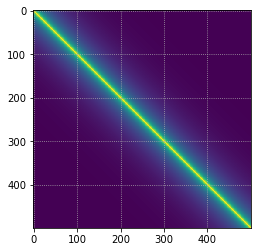

In [9]:
plt.imshow(cova)

In [10]:
target_x = 1 - cova[0:nx, 0]

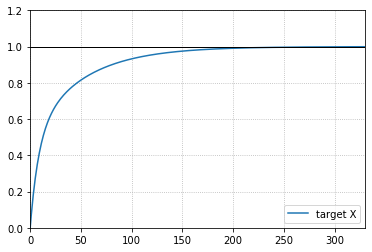

In [11]:
fig, ax = plt.subplots()
ax.plot(target_x, label="target X")
ax.axhline(1.0, c="k", lw=1)
ax.set_ylim(0, 1.2)
ax.set_xlim(0, nx * 0.66)
ax.legend(loc=4)

# Factor Variogram Models

In [12]:
sph_fact = 5
exp_fact = 5
gau_fact = 5
n_fact = sph_fact + exp_fact + gau_fact

max_range = int(nx * 0.25)
min_range = int(nx * 0.025)

sph_ranges = np.linspace(min_range, max_range, num=sph_fact, endpoint=False)
exp_ranges = np.linspace(min_range, max_range, num=exp_fact, endpoint=False)
gau_ranges = np.linspace(min_range, max_range, num=gau_fact, endpoint=False)

sph_struct = [1] * sph_fact
exp_struct = [2] * exp_fact
gau_struct = [3] * gau_fact

ranges = np.concatenate((sph_ranges, exp_ranges, gau_ranges))
structs = np.concatenate((sph_struct, exp_struct, gau_struct))

In [13]:
structs

array([1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3])

In [14]:
ranges

array([ 12. ,  34.6,  57.2,  79.8, 102.4,  12. ,  34.6,  57.2,  79.8,
       102.4,  12. ,  34.6,  57.2,  79.8, 102.4])

In [15]:
for i, (st, rnge) in enumerate(zip(structs, ranges)):
    print(i + 1, st, rnge)

1 1 12.0
2 1 34.6
3 1 57.2
4 1 79.80000000000001
5 1 102.4
6 2 12.0
7 2 34.6
8 2 57.2
9 2 79.80000000000001
10 2 102.4
11 3 12.0
12 3 34.6
13 3 57.2
14 3 79.80000000000001
15 3 102.4


# Factor Simulation
- Each initial factor is simulated with a different random number seed and a completely different variogram
- Each initial factor has a single pure structure that reflects something with unique spatial correlation that could translate to something combined with other factors

In [16]:
Y = np.zeros([nxy, n_fact + 1])
Y[:, 0] = rng.normal(size=nxy)
C = []
for i, (st, rnge) in enumerate(zip(structs, ranges)):
    if st < 3:
        cova = sim.pairwisecova_1D(
            P, ranges=[rnge], vtypes=[st], c0=0.0, cc=[1.0]
        )
    else:  # small nugget to avoid singular matrix with Gaussian model
        cova = sim.pairwisecova_1D(
            P, ranges=[rnge], vtypes=[st], c0=0.001, cc=[0.999]
        )
    Y[:, i + 1] = sim.lusim(cova, nr=1, seed=78451 + i * 1000)
    C.append(cova)

In [17]:
Y.shape

(500, 16)

-0.05 0.98
-0.15 1.06
-0.01 0.87
-0.38 1.35
0.27 1.08
-0.21 0.76
0.18 0.9
0.07 1.04
0.06 0.84
0.08 0.86
-0.13 0.71
0.11 0.87
-0.15 0.89
-0.04 0.78
-0.39 0.67
-0.52 1.05


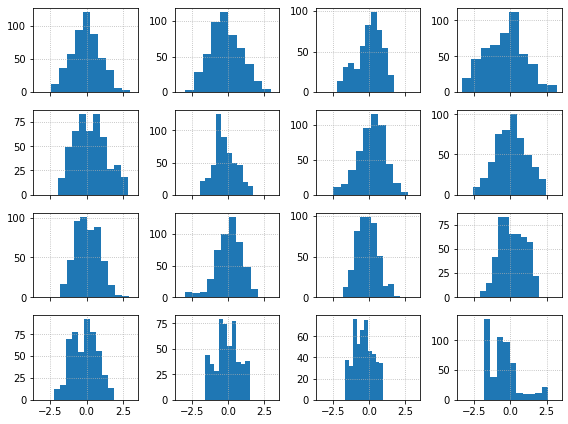

In [18]:
fig, axes = plt.subplots(4, 4, figsize=(8, 6), sharex="all")
for i, ax in enumerate(axes.flatten()):
    ax.hist(Y[:, i])
    print(np.round(np.mean(Y[:, i]), 2), np.round(np.std(Y[:, i]), 2))
fig.tight_layout()

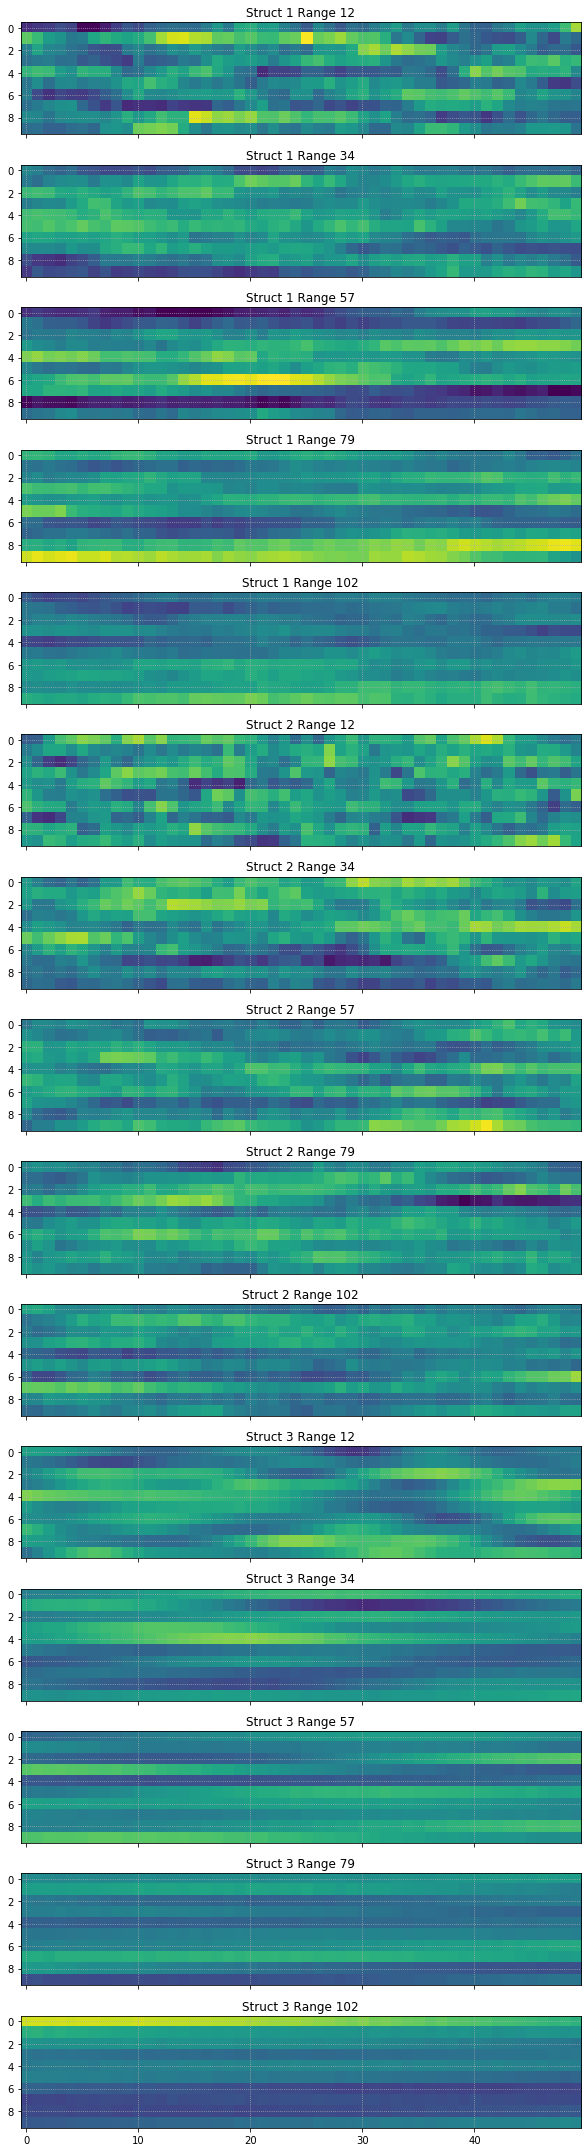

In [19]:
fig, axes = plt.subplots(15, 1, figsize=(10, 30), sharex="all")
for i, (ax, st, rnge) in enumerate(zip(axes.flatten(), structs, ranges)):
    ax.imshow(Y[:, i + 1].reshape(10, 50), vmin=-3, vmax=3)
    ax.set_title(f"Struct {st} Range {int(rnge)}")
fig.tight_layout()

# Network LMR
- Mix the pool of factors with the goal of reproducing the LMR
- Exponential factors of short and long-ish ranges should recive the most weight

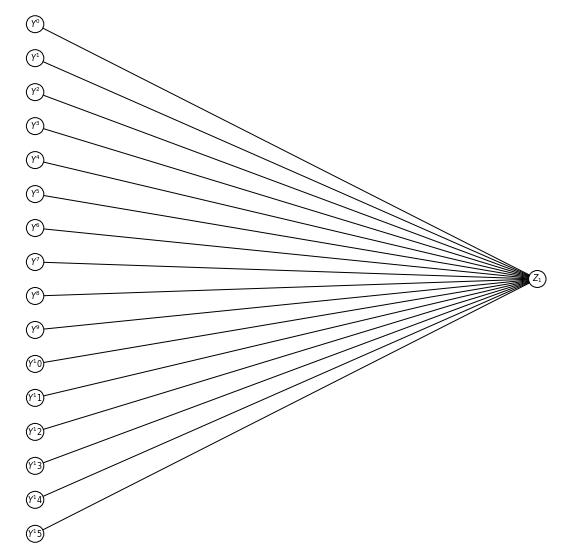

In [20]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.axis("off")
layer_dims = [n_fact + 1, 1]
draw_neural_net(ax, 0.05, 0.95, 0.0, 1.0, layer_dims, "Y", "A", "Z", 8)

In [21]:
parameters = nn.intitialize_layer_params(layer_dims, 5841044)

In [22]:
parameters

{'W1': array([[ 0.00469557, -0.00222337, -0.00651573, -0.0099477 , -0.00158045,
         -0.00793664,  0.00838881, -0.00819162,  0.01329248, -0.00830408,
          0.0132159 , -0.00146058,  0.00769741, -0.00723913,  0.00451328,
          0.00707415]]),
 'b1': array([[0.]])}

In [23]:
connections = []
for k, v in parameters.items():
    if "W" in k:
        connections.append(v.shape[0] * v.shape[1])
    print(k, "shape:", v.shape)
tconn = np.sum(connections)
print("Total connections:", tconn)

W1 shape: (1, 16)
b1 shape: (1, 1)
Total connections: 16


In [24]:
AL = nn.linear_forward(Y, parameters, nn.sigmoid)

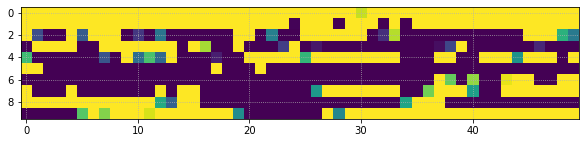

In [25]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.imshow(AL.reshape(10, 50), vmin=-3, vmax=3)

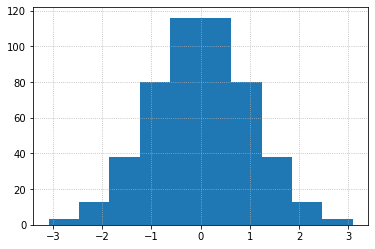

In [26]:
_ = plt.hist(AL)

In [27]:
gx = obj.griddedgam(AL)

In [28]:
AL.shape

(500,)

(0, 330.0)

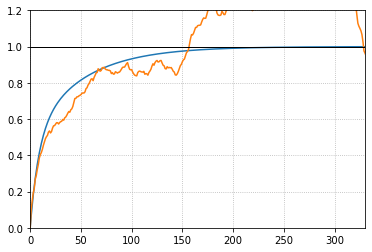

In [29]:
fig, ax = plt.subplots()
ax.plot(target_x)
ax.plot(gx / np.var(AL))
ax.axhline(1.0, c="k", lw=1)
ax.set_ylim(0, 1.2)
ax.set_xlim(0, nx * 0.66)

In [30]:
obj.objective_vario(true=target_x, pred=gx, i=0, j=max(xranges_t), scale=1.0)

0.8942127353598578

In [31]:
def network_lmr_objective_1D(x, *args):
    """objective function for network lmr"""

    # params, connections, Y, nx, ny, tx,
    # ty, sr, lr, wt_sr, wt_lr = args

    L = len(parameters) // 2
    num_wts = np.cumsum([0] + connections)

    # reshape 1D vector into appropriate matrices
    for ell in range(1, L + 1):
        shape = parameters["W" + str(ell)].shape
        parameters["W" + str(ell)] = x[num_wts[ell - 1] : num_wts[ell]].reshape(
            shape
        )
    # caluclate the forward pass
    AL = nn.linear_forward(Y, parameters, nn.relu)

    # calculate the gridded varaiograms
    gx = obj.griddedgam(AL)

    # calculate sum of squares
    loss_sr = 0.0
    loss_lr = 0.0
    loss_sr = obj.objective_vario(true=target_x, pred=gx, i=0, j=sr, scale=1.0)
    loss_lr = obj.objective_vario(true=target_x, pred=gx, i=sr, j=lr, scale=1.0)

    return loss_sr * wt_sr + loss_lr * wt_lr

In [32]:
sr = 25
lr = 200
wt_sr = 1.0
wt_lr = 1.0
afunc = nn.sigmoid
args = (parameters, connections, Y, nx, target_x, afunc, sr, lr, wt_sr, wt_lr)
results = list(
    opt.de(
        network_lmr_objective_1D,
        args,
        bounds=[(0, 1)] * tconn,
        popsize=15,
        mut=0.7,
        crossp=0.9,
        its=200,
        seed=21,
    )
)

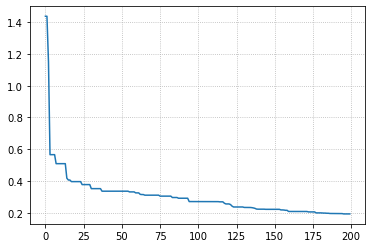

In [33]:
objective = []
for result in results:
    objective.append(result[1])
plt.plot(objective)

In [34]:
results[-1]

(array([0.0047119 , 0.04634757, 0.01890115, 0.41040383, 0.15662518,
        0.69213841, 0.42041149, 1.        , 0.31237232, 0.20488149,
        0.80653808, 0.53771963, 0.0502277 , 0.20881653, 0.0997251 ,
        0.91712881]),
 0.19243486842070323)

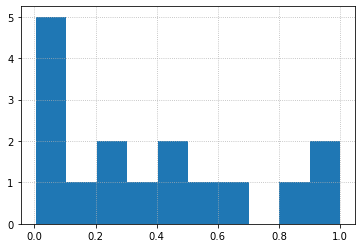

In [35]:
_ = plt.hist(results[-1][0])

In [36]:
de_params = parameters.copy()
de_weights = []
num_wts = np.cumsum([0] + connections)
for ell in range(1, len(parameters) // 2 + 1):
    shape = de_params["W" + str(ell)].shape
    de_params["W" + str(ell)] = results[-1][0][
        num_wts[ell - 1] : num_wts[ell]
    ].reshape(shape)
    de_weights.append(de_params["W" + str(ell)])

In [37]:
# fig, axes = plt.subplots(1, len(layer_dims[1:]))
# for i, ax in enumerate(axes.flatten()):
#     im = ax.matshow(de_params["W" + str(i + 1)].T, cmap="Spectral_r")
#     ax.grid()
# plt.colorbar(im)

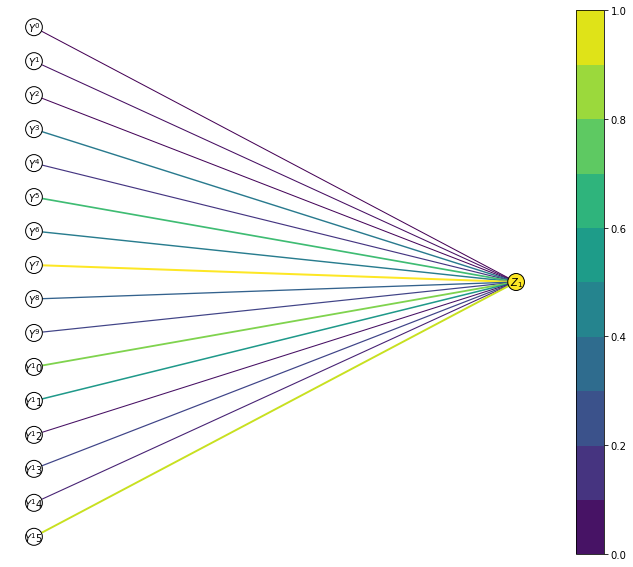

In [38]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.axis("off")
cmap = "viridis"  # "Spectral_r"
draw_weighted_neural_net(
    ax,
    0.05,
    0.95,
    0.0,
    1.0,
    layer_dims,
    "Y",
    "A",
    "Z",
    10,
    node_wts=de_weights,
    edge_wts=de_weights,
    cmap=cmap,
)
sm, _ = get_rgb(0, cmap, 0, 1)
plt.colorbar(sm, boundaries=np.arange(0, 1.1, 0.1))

In [39]:
de_params

{'W1': array([[0.0047119 , 0.04634757, 0.01890115, 0.41040383, 0.15662518,
         0.69213841, 0.42041149, 1.        , 0.31237232, 0.20488149,
         0.80653808, 0.53771963, 0.0502277 , 0.20881653, 0.0997251 ,
         0.91712881]]),
 'b1': array([[0.]])}

In [40]:
de_AL = nn.linear_forward(Y, de_params, afunc)
gx = obj.griddedgam(de_AL)

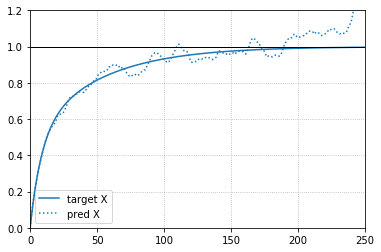

In [41]:
fig, ax = plt.subplots()
ax.plot(target_x, c="C0", label="target X")
ax.plot(gx, c="C0", ls=":", label="pred X")
ax.axhline(1.0, c="k", lw=1)
ax.set_ylim(0, 1.2)
ax.set_xlim(0, nx * 0.5)
ax.legend()

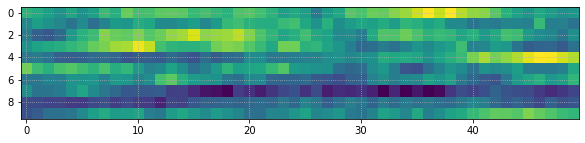

In [42]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.imshow(de_AL.reshape(10, 50), vmin=-2.5, vmax=2.5)

(array([  3.,  13.,  38.,  80., 116., 116.,  80.,  38.,  13.,   3.]),
 array([-3.09023231e+00, -2.47218584e+00, -1.85413938e+00, -1.23609292e+00,
        -6.18046461e-01,  9.90318938e-14,  6.18046461e-01,  1.23609292e+00,
         1.85413938e+00,  2.47218584e+00,  3.09023231e+00]),
 <a list of 10 Patch objects>)

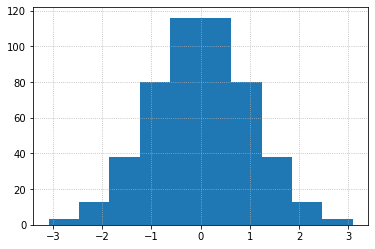

In [43]:
plt.hist(de_AL)